## C S 329E HW 9

# Clustering with K-means and DBSCAN

## Louie Wang (zw5565)

For this week's homework we are going explore two clustering methods:

  - K-Means, and
  - DBSCAN
  
As we discussed in lecture, k-means creates clusters based on a distance measure, and DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Part 1 : K-Means

In the first half of the homework, we will implement the Algorithm 7.1 "Basic K-means", and apply that algorithm to a small data set provided with the assignment in the `data_kmeans.csv` file. We will build up some helper functions along the way, test them, and put it all together to apply to our small example data set. 

In [2]:
# loading in our toy data
df_kmeans = pd.read_csv('data_kmeans.csv')

## Q1.1 - Write a function that returns `k` random rows from a data frame

To initialize the centroids, we pick `k` random points from a data frame.  Write a function `init_centroids( df_data, k )` that accepts two parameters: a data frame `df_data`, and an integer `k`, and returns the initial centroids for our k-means algorithm.  Note, we want the indices of the returned data frame to range from 0 - (k-1) so that we can use these as the centroid labels.  Use [pandas sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method, and pass it the value of $42$ for `random_state`. 

In [3]:
def init_centroids( df_data, k ):
    randomized = df_data.sample(k, random_state = 42)
    centroids = randomized.reset_index(drop = True)
    return centroids

In [4]:
# Testing our init centroid function
df_centroids = init_centroids(df_kmeans, 7)
df_centroids

,x,y
0,-0.633437,0.488756
1,-0.597736,0.632194
2,-0.635867,0.166613
3,-0.539351,-0.875532
4,-0.588597,0.293062
5,-0.127985,-0.136639
6,0.342579,0.211717


## Q1.2 - Write a function to assign every row in a data frame to a centroid 

Write a function, `assign_to_centroid`, that accepts two parameters: a data frame, `df_data`, that represents our data to be clustered, and the data frame, `df_centroids`, which is of length `k` and contains the current centroids for our clusters.  The functions returns a series of the same length of `df_data` that contains the index of the closest centroid in `df_centroid`.  Use Euclidean distance as your distance measure. 

For example, if a row of data contained the data point $(100,123)$ and the three centroids were in a data frame that had the following information:

  - Index 0 : (34,34)
  - Index 1 : (0,1)
  - Index 2 : (83,99)

The `assign_to_centroid` function would assign the index $2$ to that row of data. 

In [5]:
def assign_to_centroid( df_data, df_centroids ):
    assigned = []
    for idx, data in df_data.iterrows():
        dist = []
        for indx, value in df_centroids.iterrows():
            dist.append(np.linalg.norm(data-value))
        assigned.append(dist.index(min(dist)))
    return pd.Series(assigned)

'''
def assign_to_centroid( df_data, df_centroids ):
    centroid_index = []
    for indx, row in df_data.iterrows():
        centroid_index.append(np.argmin(np.linalg.norm(row - df_centroids, axis = 1)))
    return pd.Series(centroid_index)
'''

In [6]:
# Check how many data points were assigned to each centroid
s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
s_centroid_assignment.value_counts()

6    126
1     94
3     71
5     58
0     53
2     26
4     22
dtype: int64

## Q1.3 - Write a function that recomputes the centroids

Write a function `compute_centroids` that takes two parameters: the data frame, `df_data` containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, `s_centroid_assignment`. The function will return the a data frame containing the centroids (mean) value for each unique centroid. 

Note that the indices in the returned data frame should correspond to the unique values in `s_centroid_assignment`.  For example, if I found the mean value of df_data using the slice corresponding to `s_centroid_assigment == 2`, then the centroid should be in the returned data frame at `.iloc[2]`. 


In [7]:
def compute_centroids( df_data, s_centroid_assignment ):
    df_new = pd.DataFrame(columns = df_data.columns)
    df_temp = df_data.copy()
    df_temp['centroids'] = s_centroid_assignment
    for idx in range(7):
        df = df_data[df_temp['centroids'] == idx]
        df_mean = pd.DataFrame([df.mean()], columns = df_data.columns)
        df_new = pd.concat([df_new, df_mean], ignore_index = True)
    return df_new

'''
def compute_centroids( df_data, s_centroid_assignment ):
    df_new = pd.DataFrame(columns = df_data.columns)
    for c in range(s_centroid_assignment.max() + 1):
        rows = s_centroid_assignment.loc[s_centroid_assignment == c].index
        df_new = df_new.append(df_data.iloc[rows].mean(), ignore_index = True)
    return df_new
'''

In [8]:
# Test it out
df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids

,x,y
0,-0.715983,0.500552
1,-0.721574,0.708343
2,-0.738268,-0.113830
3,-0.696694,-0.699028
4,-0.546913,0.321364
5,-0.102365,-0.188876
6,0.523364,0.238569


## Q1.4 - Write a function that compares two centroid data frames

The stopping criterion for k-means is when our centroids have not moved since the last iteration.  Write a function `compare_centroids` that is given 2 centroid data frames, `df_centroid_a`, and `df_centroid_b` as parameters and returns `True` or `False` indicating if the centroids at each unique index in the data frame are equal. Use the [equals](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.equals.html) method to compare equality of pandas Series objects. 

In [9]:
def compare_centroids( df_centroid_a, df_centroid_b ):
    if df_centroid_a.shape != df_centroid_b.shape:
        return False
    check = 0
    for i in range(len(df_centroid_a)):
        if df_centroid_a.iloc[i].equals(df_centroid_b.iloc[i]):
            check += 1
        else:
            check += 0
    if check == len(df_centroid_a):
        return True
    else:
        return False
    
'''
def compare_centroids( df_centroid_a, df_centroid_b ):
    for index in range(len(df_centroid_a)):
        if not (df_centroid_a.iloc[index]).equals(df_centroid_b.iloc[index]):
            return False
    return True
'''

In [10]:
# Test it out, should print True followed by False
print(compare_centroids( df_new_centroids, df_new_centroids ))
print(compare_centroids( df_new_centroids, df_centroids ))

True
False


## Q1.5 - Write a function that implements k-means

Write a function, `k_means`, that takes in as parameters 2 values, a data frame with values to cluster, `df_data`, and the number of clusters to form, `k`.  The function should return a series of data of the same length as `df_data` that contains the cluster assignment (an integer from 0 to (k-1)) for each row of data.  Use the helper functions defined in the prior questions. 

In [11]:
def k_means( df_data, k ):
    df_centroid_a = init_centroids(df_data,k)
    no_change = False
    while not no_change:
        centroid_assignment = assign_to_centroid(df_data, df_centroid_a)
        df_centroid_b = compute_centroids(df_data, centroid_assignment)
        
        if compare_centroids(df_centroid_b, df_centroid_a):
            no_change = True
        else:
            df_centroid_a = df_centroid_b
    return centroid_assignment


'''
def k_means( df_data, k ):
    df_centroids = init_centroid(df_data, k)
    
    while True:
        s_cluster_assignment = assign_to_centroid(df_data, df_centroids)
        df_new_centroids = compute_centroids(df_data, s_cluster_assignment)
        
        if compare_centroids(df_centroids, df_new_centroids):
            break
        else:
            df_centroids = df_new_centroids
    return s_cluster_assignment
'''

In [12]:
# Call k_means with k = 5 to test
s_cluster_assignment = k_means( df_kmeans, 5)
s_cluster_assignment.value_counts()

0    178
3     89
2     74
4     63
1     46
dtype: int64

## Q1.6 - Plot the results

Plot the points in the `df_kmeans` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`).  Label your axes, and give the plot a title. 

Text(0.5, 1.0, 'K-Mean Clustering')

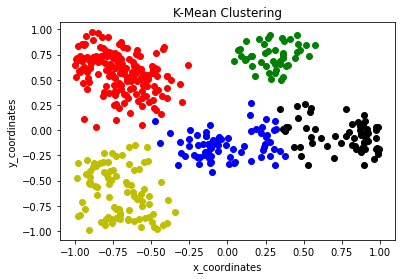

In [13]:
# Plot each cluster
ax = plt.gca()
temp = df_kmeans.copy()
temp['centroid'] = s_cluster_assignment
color = ['r','g','b','y','black']
for i in range(5):
    df_x = df_kmeans[temp['centroid'] == i]['x']
    df_y = df_kmeans[temp['centroid'] == i]['y']
    ax.scatter(df_x, df_y, c = color[i])
plt.xlabel('x_coordinates')
plt.ylabel('y_coordinates')
plt.title('K-Mean Clustering')
plt.show()

'''
for k in s_cluster_assignment.unique():
    plt.plot(df_kmeans['x'][s_cluster_assignment == k], df_kmeans['y'][s_cluster_assignment == k], '.', alpha = 0.5)
'''

# Part 2 : DBSCAN

## Q2.1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. 

Text(0.5, 1.0, 'K-Mean Clustering Attempt')

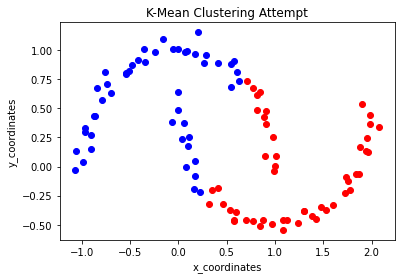

In [14]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Call k_means with k = 2
s_cluster_assignment = k_means( df_dbscan, 2)

ax = plt.gca()
temp = df_dbscan.copy()
temp['centroid'] = s_cluster_assignment
color = ['r','b']
for i in range(2):
    df_x = df_dbscan[temp['centroid'] == i]['x']
    df_y = df_dbscan[temp['centroid'] == i]['y']
    ax.scatter(df_x, df_y, c = color[i])
plt.xlabel('x_coordinates')
plt.ylabel('y_coordinates')
plt.title('K-Mean Clustering Attempt')

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [15]:
def range_query( df_data, q_index, eps ):
    neighbors = []
    Q = df_data.iloc[q_index]
    for idx, value in df_data.iterrows():
        dist = np.linalg.norm(value - Q)
        if dist <= eps:
            neighbors.append(idx)
    return df_data.iloc[neighbors]

'''
def range_query( df_data, q_index, eps ):
    d = df_data.apply(lambda x: np.linalg.norm(x - df_data.iloc[q_index]), axis = 1)
    return df_data[d <= eps]
'''

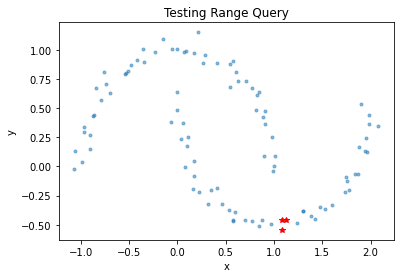

In [16]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [17]:
def dbscan( df_data, eps, min_pts ):
    NOISE = 0
    C = 0
    label = pd.Series([-1] * len(df_dbscan),index=[i for i in range(len(df_dbscan))],dtype=float)
    for P, value in df_data.iterrows():
        if label[P] != -1:
            continue
        N_outer = range_query(df_data, P, eps)
        if len(N_outer) < min_pts:
            label[P] = NOISE
            continue
        C += 1
        label[P] = C

        S_list = [P]
        i = 0
        
        while i < len(S_list):    
            P = S_list[i]
            N_inner = range_query(df_data, P, eps)
            if len(N_inner) < min_pts:
                i += 1
                continue
            for Q, val in N_inner.iterrows():
                if label[Q] == NOISE:
                    label[Q] = C
                if label[Q] != -1:
                    continue
                label[Q] = C                
                S_list.append(Q)            
            i += 1
    return label

In [ ]:
'''
def dbscan( df_data, eps, min_pts ):
    NOISE = 0
    s_cluster_assignment = np.ones(len(df_data)) * np.nan
    this_cluster_label = 0
    
    for (indx, row) in df_data.iterrows():
        if pd.notna(s_cluster_assignment[indx]):
            continue
            
        df_this_neighbors = range_query(df_data, indx, eps)
        
        if (len(df_this_neighbors) < min_pts):
            s_cluster_assignment[indx] = NOISE
            continue
            
        this_cluster_label += 1
        s_cluster_assignment[indx] = this_cluster_label
        
        n_indices = list(df_this_neighbors.index)
        
        for n_indx in n_indices:
            if n_indx == indx:
                continue
            if s_cluster_assignment[n_indx] == NOISE:
                s_cluster_assignment[n_indx] = this_cluster_label
            if pd.notna(s_cluster_assignment[n_indx]):
                continue
                
            s_cluster_assignment[n_indx] = this_cluster_label
            df_new_neighbors = range_query(df_data, n_indx, eps)
            if len(df_new_neighbors) >= min_pts:
                new_indices = list(df_new_neighbors.index[-df_new_neighbors.index.isin(n_indices)])
                if len(new_indices) > 0:
                    n_indices.extend(new_indices)
                    
    return pd.Series(s_cluster_assignment)
'''

In [18]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

1.0    49
2.0    48
0.0     3
dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

Text(0.5, 1.0, 'DBSCAN Clustering')

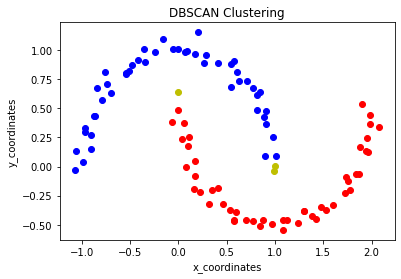

In [19]:
# Plot each cluster
ax = plt.gca()
temp = df_dbscan.copy()
temp['dbscan'] = s_cluster_assignment
color = ['y','r','b']
for i in range(3):
    x = df_dbscan[temp['dbscan'] == i]['x']
    y = df_dbscan[temp['dbscan'] == i]['y']
    ax.scatter(x, y, c = color[i])
plt.xlabel('x_coordinates')
plt.ylabel('y_coordinates')
plt.title('DBSCAN Clustering')

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

In [20]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps = 0.23, min_samples = 6).fit(df_dbscan)
sklearn_res = clustering.labels_
print('scikit-learn method labels:\n', pd.Series(sklearn_res).value_counts(),end = '\n\n')
print('our method labels:\n', s_cluster_assignment.value_counts())

scikit-learn method labels:
  0    49
 1    48
-1     3
dtype: int64

our method labels:
 1.0    49
2.0    48
0.0     3
dtype: int64


##### The scikit-learn library and my function labeled the data in the same way, with the only difference in their label values. 
##### The scikit-learn model gives noise node value -1; while our method used 0